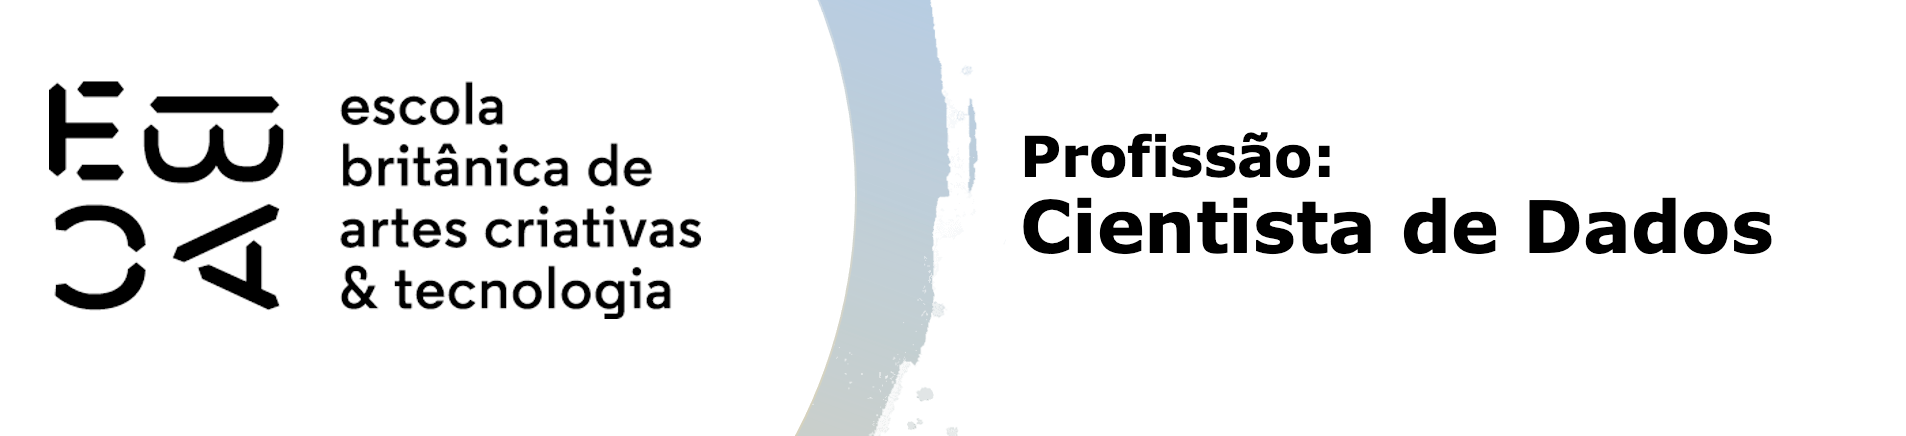

# Regressão III - Tarefa

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

from scipy.interpolate import interp1d # Vamos precisar dessa interpolação

In [17]:
df = pd.read_csv('previsao_de_renda_II.csv')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
0,2015-01-01,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14
1,2015-01-01,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81
2,2015-01-01,14111,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66
3,2015-01-01,8189,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84
4,2015-01-01,1830,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78


## Avalie valores missing e substitua pela média

Neste exercício não vamos nos preocupar com valores *missing*. Substitua-os pela média.

In [18]:
df.isna().sum()

data_ref                      0
index                         0
sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego            125760
qt_pessoas_residencia         0
renda                         0
dtype: int64

In [19]:
df['tempo_emprego'] = df['tempo_emprego'].fillna(df['tempo_emprego'].mean())
df.isna().sum()

data_ref                 0
index                    0
sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
dtype: int64

### Base de testes

Separe os três últimos meses como base *holdout* (base de teste).

In [20]:
df.data_ref = pd.to_datetime(df.data_ref)
df.data_ref[df.data_ref >= '2016'].unique()

<DatetimeArray>
['2016-01-01 00:00:00', '2016-02-01 00:00:00', '2016-03-01 00:00:00']
Length: 3, dtype: datetime64[ns]

In [21]:

X_test = df[df.data_ref >= '2016'].drop(columns=['index','data_ref'])
X_test.head()

,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
600000,F,N,S,0,Pensionista,Médio,Casado,Casa,61,7.746165,2.0,2137.61
600001,F,N,S,2,Servidor público,Superior completo,Casado,Casa,27,9.301370,4.0,13884.35
600002,F,S,S,3,Assalariado,Médio,Casado,Casa,38,10.967123,5.0,11042.47
600003,M,S,S,3,Servidor público,Médio,Casado,Casa,35,5.553425,5.0,1333.82
600004,F,S,N,0,Assalariado,Médio,Viúvo,Casa,63,9.265753,1.0,17633.03


In [22]:

X_train = df[df.data_ref < '2016'].drop(columns=['index','data_ref'])

X_train.head()

,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
0,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14
1,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81
2,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66
3,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84
4,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78


### Primeiro modelo
 Não use *index* e não use a data. Avalie o modelo com o $R^2-ajustado$

In [32]:
formula = '''renda ~ posse_de_veiculo + posse_de_imovel + qtd_filhos + tipo_renda + educacao + estado_civil + tipo_residencia + idade + tempo_emprego + qt_pessoas_residencia'''

# Ajustando o modelo com todas as variáveis
res = smf.ols(formula, data=X_train).fit()

# Obtendo o R² ajustado
r_ajustado_simples = res.rsquared_adj
print(f'R² ajustado: {r_ajustado_simples}\n')


R² ajustado: 0.24483402263658216



### Análise de perfil

Categorize a variável ```tempo_emprego``` em 20 quantis (cada categoria deve ter aproximadamente a mesma quantidade de observações) e faça uma tabela de perfil (armazene como dataframe) para esta categorização:

- Cada linha é uma categoria
- Uma coluna para a quantidade de observações de cada categoria
- Uma coluna para a média do log-renda para cada categoria
- Uma coluna para a média do tempo de emprego para cada categoria

Faça um gráfico da média do tempo de emprego pela média do log-renda. Insira uma célula de texto e comente se te parece que alguma das transformações vistas no módulo deve fornecer bons resultados.

In [24]:
X_train['tempo_emprego_cat'] = pd.qcut(X_train['tempo_emprego'], q=20,duplicates='drop',labels=False)
X_train['log_renda'] = np.log(X_train['renda'])
perfil_tempo_emprego = X_train.groupby('tempo_emprego_cat').agg({
    'tempo_emprego_cat':'size',
    'log_renda':'mean',
    'tempo_emprego':'mean'

    })
perfil_tempo_emprego.columns = ['quantidade','media_log_renda','tempo_emprego_medio']
perfil_tempo_emprego

,quantidade,media_log_renda,tempo_emprego_medio
tempo_emprego_cat,,,
0,30234,8.364965,0.515042
1,30031,8.454323,1.125014
2,29736,8.569544,1.781261
3,30013,8.624148,2.510920
4,30408,8.755365,3.301180
5,29625,8.855078,3.987156
6,30109,8.903273,4.610421
7,29991,9.049495,5.367829
8,30003,9.139216,6.205546


In [25]:
def plotar_relacao_tempo_renda(data,x='tempo_emprego_medio',y='media_log_renda'):
    """
    Plota a relação entre tempo de emprego médio e média do log da renda.
    
    Parâmetros:
    data : DataFrame
        DataFrame contendo as colunas 'tempo_emprego_medio' e 'media_log_renda'
    """
    plt.figure(figsize=(10, 6))
    plt.scatter(data[x], 
               data[y])

    plt.xlabel('Tempo de Emprego Médio')
    plt.ylabel('Média do Log da Renda')
    plt.title('Relação entre Tempo de Emprego e Log da Renda')

    # Adicionar linha de tendência
    z = np.polyfit(data[x], 
                   data[y], 1)
    p = np.poly1d(z)
    plt.plot(data[x], 
             p(data[x]), 
             "r--", alpha=0.8)

    plt.grid(True, alpha=0.3)
    plt.show()

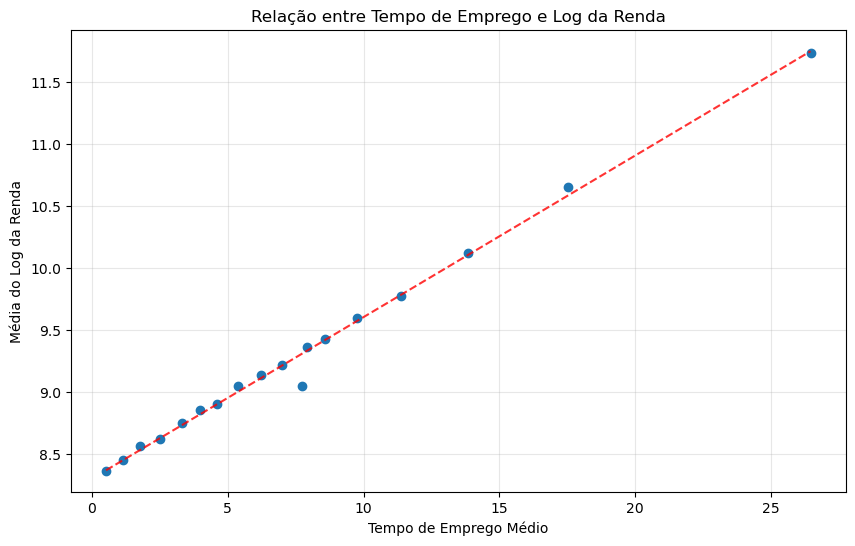

In [26]:
plotar_relacao_tempo_renda(perfil_tempo_emprego)

In [27]:
formula = '''media_log_renda ~ tempo_emprego_medio'''
# Ajustando o modelo com todas as variáveis
res = smf.ols(formula, data=perfil_tempo_emprego).fit()

# Obtendo o R² e R² ajustado
r_ajustado_perfil = res.rsquared_adj
res.rsquared

0.9933780042553378

**Avaliação**: o R² do modelo esta bem ajustado com o tempo_medio_emprego 

### Linearização

Experimente pelo menos duas técnicas de linearização vistas ao longo do módulo para melhorar o ajuste da variável ```tempo_emprego```. Compare o $R^2-ajustado$ e avalie se alguma delas apresentou resultados relevantes com relação ao primeiro modelo.


**Ajustando a quantidade da quebra e aplicando log no tempo de emprego**

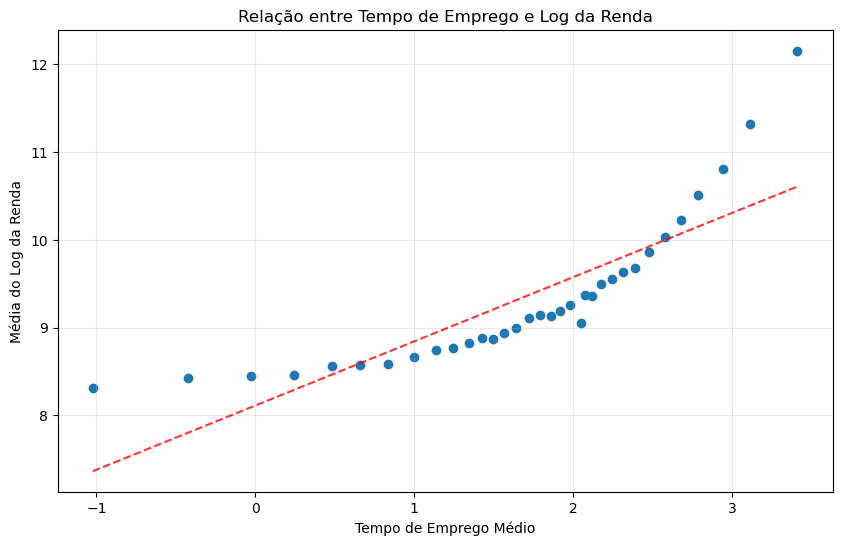

0.7153960482611752

In [ ]:
df2 = X_train.copy()
df2['tempo_emprego_log'] = np.log(df2['tempo_emprego'])#log no tempo de emprego
df2['tempo_emprego_cat'] = pd.qcut(df2['tempo_emprego_log'], q=40,duplicates='drop',labels=False)
perfil2 = df2.groupby('tempo_emprego_cat').agg({
    'tempo_emprego_cat':'size',
    'log_renda':'mean',
    'tempo_emprego_log':'mean'

    })
perfil2.columns = ['quantidade','media_log_renda','tempo_emprego_medio']

plotar_relacao_tempo_renda(perfil2)
formula = '''media_log_renda ~ tempo_emprego_medio'''
# Ajustando o modelo com todas as variáveis
res2 = smf.ols(formula, data=perfil2).fit()

# Obtendo o R² e R² ajustado
r_ajustado_perfil2 = res2.rsquared_adj
r_ajustado_perfil2


**aplicando lowess**

In [30]:

x_col='tempo_emprego_medio'
y_col='media_log_renda'
frac=2/3

# Cria cópia para não modificar o DataFrame original
df_result = perfil_tempo_emprego.copy()

# Aplica LOWESS
lowess_result = sm.nonparametric.lowess(
    df_result[y_col], 
    df_result[x_col], 
    frac=frac
)

# Extrai valores X e Y suavizados
lowess_x = lowess_result[:, 0]
lowess_y = lowess_result[:, 1]

# Cria interpolação para preencher valores
f = interp1d(lowess_x, lowess_y, bounds_error=False)

# Adiciona coluna com valores suavizados
df_result[f'{y_col}_lowess'] = f(df_result[x_col])


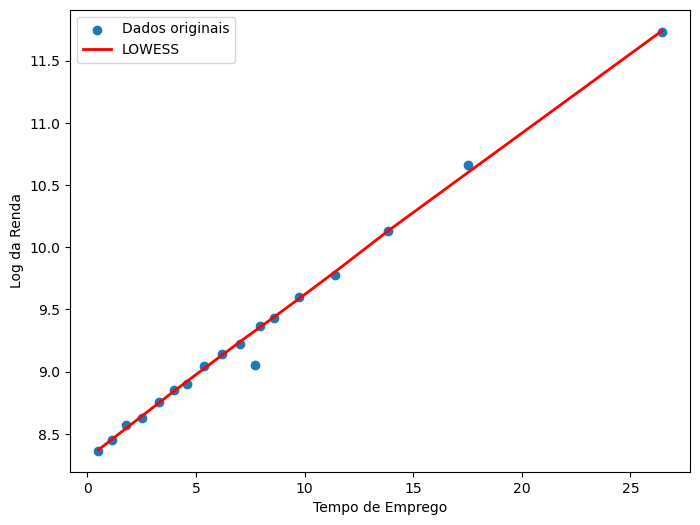

R² ajustado: 0.9928795754347557


In [ ]:
# Plotar resultado
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(df_result['tempo_emprego_medio'], df_result['media_log_renda'], 
          label='Dados originais')
ax.plot(df_result['tempo_emprego_medio'], df_result['media_log_renda_lowess'], 
        'r-', label='LOWESS', linewidth=2)
ax.set_xlabel('Tempo de Emprego')
ax.set_ylabel('Log da Renda')
ax.legend()
plt.show()

# Ajustar modelo com valores suavizados
modelo_lowess = smf.ols('media_log_renda ~ media_log_renda_lowess', data=df_result).fit()
r_ajustado_lowess = modelo_lowess.rsquared_adj
print(f'R² ajustado: {r_ajustado_lowess}')

### Avaliando o modelo

Avalie os resultados dos modelos construidos na base de testes.

In [34]:
r_ajustado_list = [r_ajustado_lowess,r_ajustado_perfil,r_ajustado_perfil2,r_ajustado_simples]
tecnica = ['LOWESS de log Renda','Log Renda','Log Renda e Tempo emprego','Simples']

resultados = pd.DataFrame({
    'tecnica': tecnica,
    'R²_ajustado': r_ajustado_list
})

resultados

,tecnica,R²_ajustado
0,LOWESS de log Renda,0.992880
1,Log Renda,0.992964
2,Log Renda e Tempo emprego,0.715396
3,Simples,0.244834


**Lowess e categorização com log na renda apresentam melhores valores de R² ajustado.**